# Naive Sentence to Emoji Translation 
## Purpose
To workshop a naive version of an sentence to emoji translation algorithm. The general idea is that sentences can be "chuncked" out into n-grams that are more related to a single emoji. The related-ness of an n-gram to an emoji is directly related to the cosine similarity of the sent2vec representation of the sentence and the sent2vec representation of one of the emoji's definitions. The emoji definitons are gathered from the [emoji2vec](https://github.com/uclmr/emoji2vec) github repo and the sent2vec model is from the [sent2vec](https://github.com/epfml/sent2vec) github repo. 

For a better explanation of the algorithm please see our [paper](https://www.authorea.com/users/269084/articles/396929-confet-an-english-to-emojis-translation-algorithm) or the [slides] from our presentation

In [1]:
# NOTE: If this is the first time
# !pip install spacy
# !pip install tabulate
# !pip install ../../sent2vec/

# Standard Library
from typing import List, Tuple, Callable # Datatypes for the function typing
from functools import lru_cache         # Function annotation for storing results 
from dataclasses import dataclass, field # C-like struct functions and class annotation
from string import punctuation

# Scipy suite
import numpy as np                       # For function annotation
from scipy.spatial.distance import cosine # Distance between sentence and emoji in sent2vec vector space

# NLTK
from nltk import word_tokenize, pos_tag                                # Tokenizing a sentence into words and tagging POS
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer # Different stemming algorithms
from nltk.corpus import stopwords                                      # Define the set of stopwords in english
from nltk import Tree
stopwords = " " #set(stopwords.words('english'))

# Import spacy (NLP)\n",
import spacy

# Import sentence vectorizer\n"
import sent2vec

# IPython output formatting\n",
from tabulate import tabulate                           # Tabulation from 2-d array into html table
from IPython.display import display, HTML, clear_output # Nice displaying in the output cell
import warnings; warnings.simplefilter('ignore')        # cosine distance gives warnings when div by 0 so
                                                        # ignore all of these
# Timing functions
from time import time, localtime, strftime

In [2]:
# Paramatize the file locations
emoji_file = "../data/emoji_joined.txt" # https://github.com/uclnlp/emoji2vec/blob/master/data/raw_training_data/emoji_joined.txt
wikipedia_file = "../data/wikipedia_utf8_filtered_20pageviews.csv" # https://blog.lateral.io/2015/06/the-unknown-perils-of-mining-wikipedia/

In [3]:
# Initialize the sent2vec model
s2v = sent2vec.Sent2vecModel()
s2v.load_model('../../models/wiki_unigrams.bin') # https://drive.google.com/open?id=0B6VhzidiLvjSa19uYWlLUEkzX3c

In [4]:
# Intitialize the lemmatizers
# !python -m spacy download en
ps = PorterStemmer()
sb = SnowballStemmer("english")
lemmatizerNLTK = WordNetLemmatizer()
nlp = spacy.load("en")

## Sentence Cleaning
The general idea with sentence cleaning is that the sentences need to be put into the same "format" for better analysis. There are two main aspects of cleaning: 1) removal, and 2) modification. Removal is primarily for tokens that do not contribute to the sentence at all. These include ".", "and", "but". Normally this is a standard step in sentence cleaning but it has actually has zero effect on the output that I can see. However, token modification changes the spelling of tokens to uniform all tokens that use the same root. For example "rocked", "rock", "rocking" should all be reduced to their lemma of "rock". There are two different ways to do this: [stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html). 

In [5]:
def clean_sentence(sent: str, lemma_func: Callable[[str], str]=lemmatizerNLTK.lemmatize, keep_stop_words: bool=True) -> str:
    """
    Clean a sentence
    
    Tokenize the word and then lemmatize each individual word before rejoining it all together.
    Optionally removing stop words along the way
        
    Args:
        sent(str): Sentence to clean
        lemma_func(Callable[[str], str]): A function that takes in a word and outputs a word,
                                          normally used to pass in the lemmatization function to be mapped
                                          on every word the sentence
        keep_stop_words(bool): Keep the stop words in the sentence
    Rets:
        (str): Cleaned sentence
    """
    # Lemmatize each word in the sentence and remove the stop words if the flag is set
    return " ".join([lemma_func(token) for token in word_tokenize(sent.lower()) if (token not in stopwords or keep_stop_words) and (token not in punctuation)])

#### Emoji Vectorization and Related

In [6]:
# Define the array to store the (emoji, repr) 2-tuple
def generate_emoji_embeddings(lemma_func: Callable[[str], str]=lemmatizerNLTK.lemmatize, keep_stop_words: bool=True) -> List[Tuple[str, List[float]]]:
    """
    Generate the sent2vec emoji embeddings from the input file
    
    Run each emoji within the emoji_joined data file from the emoji2vec paper through
    the sent2vec sentence embedder. This is a very naive way of doing it because one
    emoji may have multiple entries in the data file so it has multiple vectors in the
    emoji_embeddings array
    
    Args:
        lemma_func(Callable[[str], str]): Lemmatization function for cleaning. A function that takes in a word and outputs a word,
                                          normally used to pass in the lemmatization function to be mapped
                                          on every word the sentence
        keep_stop_words(bool): Keep the stop words in the cleaned sentence
    Rets:
        (List[Tuple[str, List[float]]]): A list of 2-tuples containing the emoji and 
                                         one vector representation of it
    """
    
    # Initialize the list that will hold all of the embedings
    emoji_embeddings = []
    
    # Open the file that stores the emoji, description 2-tuple list
    with open(emoji_file) as emojis:
        for defn in emojis:
            # The file is tab-delim
            split = defn.split("\t")

            # Get the emoji and the description from the current line
            emoji = split[-1].replace("\n", "")
            desc = clean_sentence(split[0], lemma_func, keep_stop_words)

            # Add each emoji and embedded description to the list
            emoji_embeddings.append((emoji, s2v.embed_sentence(desc), desc))
            
    # Return the embeddings
    return emoji_embeddings

emoji_embeddings = generate_emoji_embeddings()

In [7]:
@lru_cache(maxsize=1000)
def closest_emoji(sent: str, return_all: bool=False) -> Tuple[str, int]:
    """
    Get the closest emoji to the given sentence
    
    Loop through the list of emoji embeddings and keep track of which one has the
    lowest cosine distance from the input sentence's embedding. This is the "closest"
    emoji. The lru_cache designation means that python will store the last [maxsize]
    calls to this function with their return value to reduce computation. This is
    cleared after every call to the summary function.
    
    Args:
        sent(List[str]): Sentence to check
        return_all(bool, Optional): Return all minimum emojis rather than just the first
    Ret:
        (Tuple[str, int]) Closest emoji, cosine similarity of emoji
    
    """    
    # Embed the sentence using sent2vec 
    emb = s2v.embed_sentence(sent)

    # Check the similarity between each emoji and the sentence. The tuple
    # is in the format (emoji, cosine diff, emoji desc)
    emoji_sent_diffs = [(emoji[0], cosine(emoji[1], emb), emoji[2])
                               for emoji in emoji_embeddings]
    
    min_val = min(emoji_sent_diffs, key=lambda e: e[1])[1]
    
    # Return the entry with the lowest cosine diff
    good_emojis = [emoji for emoji in emoji_sent_diffs
                   if emoji[1] == min_val]
    
    return good_emojis[0]
    
    if len(good_emojis) == 1:
        return good_emojis[0]
#     else:
# other_keyword_embeddings = [emoji for emoji]

closest_emoji("her royal highness")

('🎎', 0.4567180275917053, 'royal')

In [8]:
@lru_cache(maxsize=1000)
def closest_emoji(sent: str, return_all: bool=False) -> Tuple[str, int]:
    """
    Get the closest emoji to the given sentence
    
    Loop through the list of emoji embeddings and keep track of which one has the
    lowest cosine distance from the input sentence's embedding. This is the "closest"
    emoji. The lru_cache designation means that python will store the last [maxsize]
    calls to this function with their return value to reduce computation. This is
    cleared after every call to the summary function.
    
    Args:
        sent(List[str]): Sentence to check
        return_all(bool, Optional): Return all minimum emojis rather than just the first
    Ret:
        (Tuple[str, int]) Closest emoji, cosine similarity of emoji
    
    """    
    # Embed the sentence using sent2vec 
    emb = s2v.embed_sentence(sent)

    # Check the similarity between each emoji and the sentence. The tuple
    # is in the format (emoji, cosine diff, emoji desc)
    emoji_sent_diffs = [(emoji[0], cosine(emoji[1], emb), emoji[2])
                               for emoji in emoji_embeddings]
    
    min_val = min(emoji_sent_diffs, key=lambda e: e[1])
    return min_val

    # Return the entry with the lowest cosine diff
    good_emojis = [emoji for emoji in emoji_sent_diffs
                   if emoji[1] == min_val]
    
    return good_emojis[0]
    
    if len(good_emojis) == 1:
        return good_emojis[0]
#     else:
# other_keyword_embeddings = [emoji for emoji]

closest_emoji("her royal highness")

('🎎', 0.4567180275917053, 'royal')

#### N-Gram Generation and Related

In [9]:
def pos_n_gram(sentence: str, keep_stop_words: bool=True) -> List[str]:
    """
    Generate an n-gram based on the POS tagged dependency tree of the sentence that is "simplified" down according
    to a few assumptions that dictate a good sentence split. These assumptions are as follows:
        1. If two words are leafs and on the same level with the same parent they can be grouped as an n-gram
        2. If there is a sequence of parent-child relationships with only 1 child they can be grouped as one
           n-gram
           
    
    """
    stopword = "the in has be".split()
    pos_tagged_n_grams = []
    
    def to_nltk_tree(node):
        current_node = node
        backlog = []
        while current_node.n_lefts + current_node.n_rights == 1:
            backlog.append((current_node.orth_, current_node.i))
            current_node = list(current_node.children)[0]

        backlog.append((current_node.orth_, current_node.i))
        if current_node.n_lefts + current_node.n_rights > 1:
            good_children = [child for child in current_node.children if len(list(child.children)) > 0]
            bad_children = [(child.orth_, child.i) for child in current_node.children if child not in good_children]
            pos_tagged_n_grams.append(backlog)
            pos_tagged_n_grams.append(bad_children)
            return Tree(backlog, [Tree(bad_children, [])] + [to_nltk_tree(child) for child in good_children])
        else:
            pos_tagged_n_grams.append(backlog)
            return Tree(backlog, [])
        
    def strip_nothing_unigrams(n_grams):
        return [n_gram for n_gram in n_grams if not (len(n_gram.split(" ")) == 1 and n_gram.split(" ")[0] in stopword)]

    query = " ".join([word for word in sentence.split() if word not in stopword or keep_stop_words])
    doc = nlp(query)
    to_nltk_tree(list(doc.sents)[0].root);
    # print(nltk_tree)

    sort_inner = [sorted(nltk_child, key=lambda x: x[1]) for nltk_child in pos_tagged_n_grams]

    nltk_averages = []
    for nltk_child in sort_inner:
        if nltk_child == []:
            continue
        nltk_averages.append((nltk_child, max(x[1] for x in nltk_child)))

    sorted_outer = list(sorted(nltk_averages, key=lambda x: x[1]))

    n_grams = []
    for nltk_average in sorted_outer:
        n_grams.append(" ".join(word[0] for word in nltk_average[0]))
        
    
    if not keep_stop_words:
        new_n_grams = []
        for n_gram in n_grams:
            new_n_gram = " ".join([word for word in word_tokenize(n_gram) if word not in stopword])
#             print(new_n_gram)
            new_n_grams.append(new_n_gram)
        return new_n_grams
    else:
        return n_grams
        


In [10]:
def clean_n_gram(n_grams:List[str]) -> bool:
    """
    Validate that a given n_gram is good. Good is defined as the series of n-grams contains no n-grams containing only stop words
    """
    stopwords = "the and but".split()
    return list(filter(lambda x: x not in stopwords, n_grams))


In [11]:
def combinations_of_sent(sent: str) -> List[List[str]]:
    """
    Return all possible n-gram combinations of a sentence
    
    Args:
        sent(str): Sentence to n-gram-ify
    Rets:
        (List[List[str]]): List of all possible n-gram combinations
    """
    
    def combinations_of_sum(sum_to: int, combo: List[int]=None) -> List[List[int]]:
        """
        Return all possible combinations of ints that sum to some int
        
        Args:
            sum_to(int): The number that all sub-arrays should sum to
            combo(List[int]): The current combination of number that the recursive
                              algo should subdivide, not needed for first run but used
                              in every consequent recursive run of the function
        """
        # Initialize the list for combinations
        combos = []
        
        # If the current combo list is none (first run through)
        # then generate it with all 1s and length = sum_to
        if combo is None:
            combo = [1 for x in range(sum_to)]
            combos.append(combo)

        # Base case: If the length  of the combination is 0 then
        # end the recursion because we are at the top of the "tree"
        if len(combo) == 0:
            return None

        # For each 
        for i in range(1, len(combo)):
            combo_to_query = combo[:i-1] + [sum(combo[i - 1:i + 1])] + combo[i+1:]
            combos.append(combo_to_query)
            [combos.append(combo) for combo in combinations_of_sum(sum_to, combo_to_query) if combo is not None]

        return combos
    
    def combinations_of_sent_helper(sent):
        sent = word_tokenize(sent)
        combos = np.unique(combinations_of_sum(len(sent)))
        sent_combos = []
        for combo in combos:
            sent_combo = []
            curr_i = 0
            for combo_len in combo:
                space_joined = " ".join(sent[curr_i:combo_len + curr_i])
                if space_joined not in sent_combo:
                    sent_combo.append(space_joined) 
                curr_i += combo_len

            if sent_combo not in sent_combos:
                sent_combos.append(sent_combo)
        return sent_combos
    
    return combinations_of_sent_helper(sent)

### Summarization Algorithm and Related

In [12]:
@dataclass
class EmojiSummarizationResult:
    """
    "Struct" for keeping track of an Emoji Summarization result
    
    Data Members:
        emojis(str): String of emojis that represent the summarization
        n_grams(List[str]): List of variable length n-grams that each emoji represents
        uncertainty_scores(List[float]): List of the cosine distance between each n_gram and emoji
        time_elapsed(float): How long it took to complete the summary
    """
    emojis: str = ""
    emojis_n_grams: str = field(default_factory=list)
    n_grams: List[str] = field(default_factory=list)
    uncertainty_scores: List[float] = field(default_factory=list)
    elapsed_time: float = 0

In [13]:
#weighted on real estate an n-gram occupies
def score_summarization_result_weighted_average(summarization: EmojiSummarizationResult) -> float:
    weighted_sum = 0
    sentence_length = 0
    for i in range(len(summarization.uncertainty_scores)):
        sentence_length += len(summarization.n_grams[i].split(" "))
        weighted_sum += summarization.uncertainty_scores[i] * len(summarization.n_grams[i].split(" "))
  
    return weighted_sum/sentence_length

def score_summarization_result_geometric_average(summarization: EmojiSummarizationResult) -> float:
    return np.prod(summarization.uncertainty_scores)**(1/len(summarization.uncertainty_scores))

# Can do with logs - better?
def score_summarization_result_weighted_geometric_average(summarization: EmojiSummarizationResult) -> float:
    weighted_prod = 1
    sentence_length = 0
    for i in range(len(summarization.uncertainty_scores)):
        sentence_length += len(summarization.n_grams[i].split(" "))
        weighted_prod += summarization.uncertainty_scores[i] ** len(summarization.n_grams[i].split(" "))
        
    return weighted_prod ** (1/sentence_length)

def score_summarization_result_harmonic_average(summarization: EmojiSummarizationResult) -> float:
    return len(summarization.n_grams) / sum([1/uncertainty_score for uncertainty_score in summarization.uncertainty_scores])

def score_summarization_result_weighted_harmonic_average(summarization: EmojiSummarizationResult) -> float:
    total = 0
    for i in range(len(summarization.uncertainty_scores)):
        total += 1/(len(summarization.n_grams[i].split(" ")) * summarization.uncertainty_scores[i])
        
    return total



In [14]:
def score_summarization_result_average(summarization: EmojiSummarizationResult) -> float:
    """
    Score a EmojiSummarizationResult
    
    Get the average of all uncertainty scores and return that as the score
    
    Args:
        summarization(EmojiSummarizationResult): Summarization to score
        
    Rets:
        (float): Numerical summarization score
    """
    return sum(summarization.uncertainty_scores) / len(summarization.uncertainty_scores)

In [15]:
def summarize(sent:str, lemma_func: Callable[[str], str]=lemmatizerNLTK.lemmatize, 
              keep_stop_words: bool=True, scoring_func: Callable[[EmojiSummarizationResult], float]=score_summarization_result_average) -> EmojiSummarizationResult: 
    """
    Summarize the given sentence into emojis
    
    Split the sentence into every possible combination of n-grams and see which returns the highest score
    when each n-gram is translated to an emoji using the closest emoji in the dataset
    
    Args:
        sent(str): Sentence to summarize
        lemma_func(Callable[[str], str]): Lemmatization function for cleaning. A function that takes in a word and outputs a word,
                                          normally used to pass in the lemmatization function to be mapped
                                          on every word the sentence
        keep_stop_words(bool): Keep the stop words in the cleaned sentence
    Rets:
        (Tuple[List[str], List[float], List[str]]): (Emoji Sentence, 
        List of Uncertainty values for the corresponding emoji,
        list of n-grams used to generate the corresponding emoji)
    """
    # Start the timer
    time_now = time()
    
    # Clean the sentence
    sent = clean_sentence(sent, lemma_func=lemma_func, keep_stop_words=keep_stop_words)
    
    # Generate all combinations of sentences
    sent_combos = combinations_of_sent(sent)
    # Init "best" datamembers as empty or exceedingly high
    best_summarization = EmojiSummarizationResult()
    best_summarization_score = 100_000_000
    # Iterate through every combination of sentence combos
    for sent_combo in sent_combos:
        # Start the local data members as empty
        local_summarization = EmojiSummarizationResult()
        # Iterate through each n_gram adding the uncertainty and emoji to the lists
        for n_gram in sent_combo:
            close_emoji, cos_diff, close_ngram = closest_emoji(n_gram)
            local_summarization.emojis += close_emoji
            local_summarization.uncertainty_scores.append(cos_diff)
            local_summarization.emojis_n_grams.append(close_ngram)
        
        local_summarization.n_grams = sent_combo

        # Check if the average uncertainty is less than the best
        # TODO: Maybe a median check would be helpful as well?
        if scoring_func(local_summarization) < best_summarization_score:
            # Update the best emojis
            best_summarization = local_summarization
            best_summarization_score = scoring_func(best_summarization)
            
    # Clear the function cache on closest_emoji because it is unlikely the next run will make use of them
    closest_emoji.cache_clear()
    
    # Stop the timer
    best_summarization.elapsed_time = time() - time_now
    
    # Return the emoji "sentence", list of all the cosine similarities, and all of the n-grams
    return best_summarization

In [16]:
def summarize_pos(sent:str, keep_stop_words:bool=True, lemma_func: Callable[[str], str]=lambda x: x) -> EmojiSummarizationResult:
    """
    Summarize a sentence using POS n-gram chunking
    
    Args:
        sent(str): Sentence to summarize
        keep_stop_words(bool, Optional): Flag to keep the stop words when cleaning the sentence and n-grams
        lemma_func(Callable[[str], str], Optional): Function to use to lemmatize the sentence
        
    Rets:
        EmojiSummarizationResult: Result of the emoji summarization
    """
    time_now = time()
        
    # Clean the sentence
    sent = clean_sentence(sent, keep_stop_words=True, lemma_func=lemma_func)
    
    # Get the n-grams using the part of speech tagging
    pos_n_grams = pos_n_gram(sent, keep_stop_words=keep_stop_words)
    
    # Clean the n_grams
    n_grams = clean_n_gram(pos_n_grams)
    
    # Create an Emoji Summarization Result
    esr = EmojiSummarizationResult()
    
    # Translate every n_gram in that n-gram sequence
    for n_gram in n_grams:
        # Get the closest emoji to the current n-gram
        emoji, similarity, desc = closest_emoji(n_gram)
        
        # Add the closest emoji to the sumary
        esr.emojis += emoji
        esr.emojis_n_grams.append(desc)
        esr.n_grams.append(n_gram)
        esr.uncertainty_scores.append(similarity)

    # Stop the timer
    esr.elapsed_time = time() - time_now
        
    # Return the summary
    return esr

### Verification and Related

In [17]:
def format_summary(sents: List[str], lemma_func: Callable[[str], str]=lemmatizerNLTK.lemmatize, keep_stop_words: bool=True, generate_embeddings: bool=True,
                  scoring_func: Callable[[EmojiSummarizationResult], float]=score_summarization_result_average) -> HTML:
    """
    Summarize a collection of sentences and display it nicely with IPython
    
    Args:
        sents(List[str]): List of sentences to translate
        lemma_func(Callable[[str], str]), optional: Lemmatization function for cleaning. A function that takes in a word and outputs a word,
                                          normally used to pass in the lemmatization function to be mapped
                                          on every word the sentence
        keep_stop_words(bool), optional: Keep the stop words in the cleaned sentence
        generate_embeddings(bool), optional: Regenerate the emoji embeddings for the case that the lemmatazation/stop_word params have changed
        
    Rets:
        IPython.HTML: HTML List to be displayed with IPython
    
    """

    # Generate emoji embeddings in case the cleaning parameters have changed
    if generate_embeddings:
        time_now = time()
        global emoji_embeddings
        emoji_embeddings = generate_emoji_embeddings(lemma_func, keep_stop_words)
        print("Completed emoji embeddings, time elapsed: {}\n".format(time() - time_now))
    
    # Create the 2d array for the talbe
    table = []
    
    # Iterate through each sentence to be summarized
    for sent in sents:
        # Start timer
        time_now = time()
        
        # Summarize it
        summarization_res = summarize(sent, lemma_func, keep_stop_words, scoring_func)
        
        # Get elapsed time
        elapsed_time = time() - time_now
        
        # Update elapsed time
        summarization_res.elapsed_time = elapsed_time
        
        # Print status update
        # print("Completed sentence: {}, time elapsed: {}".format(sents.index(sent), elapsed_time))

        # Append pertinent data to the table
        table.append([sent, round(scoring_func(summarization_res), 3), 
                           [round(x, 3) for x in summarization_res.uncertainty_scores],
                           summarization_res.n_grams, 
                           summarization_res.elapsed_time,
                           summarization_res.emojis])
        
        # Print out an update
    
    # Return the table with the headers
    return tabulate(table, tablefmt='pipe', 
                                headers=["Input Sentence", "Summary Score", "Individual N-Gram Scores", 
                                         "N-Grams", "Elapsed Time", "Emoji Results"])


In [18]:
def pp(esr):
    print("Emojis: " + esr.emojis)
    print("Emoji n-grams: " + ", ".join(esr.emojis_n_grams))
    print("Sentence n-grams: " + ", ".join(esr.n_grams))
    print("Uncertainty Scores: " + ", ".join([str(round(x, 3)) for x in esr.uncertainty_scores]))
    print("Time: " + str(round(esr.elapsed_time, 3)) + "s")
    print("Score: " + str(round(1 - score_summarization_result_average(esr), 3)))
    print()

In [19]:
sentences = ["The happy dog shares a treat with another dog"]
for sentence in sentences:
    pp(summarize_pos(sentence, keep_stop_words=True))
    pp(summarize(sentence, keep_stop_words=False))

Emojis: 😹🐩🚻💯🍧🐩
Emoji n-grams: happy, dog, shared, a, treat, dog
Sentence n-grams: the happy, dog, shares, a, treat, with another dog
Uncertainty Scores: 0.053, 0.0, 0.582, 0.0, 0.0, 0.22
Time: 1.747s
Score: 0.857

Emojis: 😹🐩💯🍧🐩
Emoji n-grams: happy, dog, a, treat, dog
Sentence n-grams: the happy, dog share, a, treat with another, dog
Uncertainty Scores: 0.053, 0.249, 0.0, 0.219, 0.0
Time: 11.596s
Score: 0.896



### Timing and Graphing

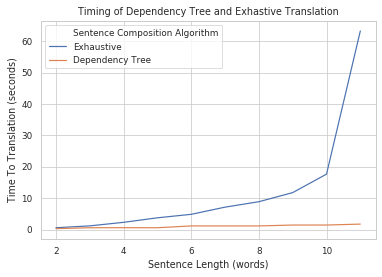

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", context="paper")

outer_sent = "the quick brown fox jumped over the lazy dog sphinx of".split(" ") # Issues with 1 word phrases. Also changed stopwords to empty list.
sent_lens = []
exh_time = []
pos_time = []
for x in range(2, len(outer_sent) + 1):
    sent = " ".join(outer_sent[:x])
    sent_lens.append(x)
    pos = summarize_pos(sent)
    exh = summarize(sent)
    pos_time.append(pos.elapsed_time)
    exh_time.append(exh.elapsed_time)

df = pd.DataFrame()
df["Sentence Length (words)"] = sent_lens
df["Exhaustive"] = exh_time
df["Dependency Tree"] = pos_time
df.head()
df_melted = pd.melt(df, ["Sentence Length (words)"])
df_melted = df_melted.rename(columns={"variable": "Sentence Composition Algorithm", "value": "Time To Translation (seconds)"})

p = sns.lineplot(data=df_melted, x="Sentence Length (words)", y="Time To Translation (seconds)", hue="Sentence Composition Algorithm", color="coral")
p.set_title("Timing of Dependency Tree and Exhastive Translation")
p.get_figure().savefig("../plots/AlgorithmTiming.png")